In [1]:
import tensorflow as tf
from tensorflow import keras
print("Number of GPUS : ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Number of GPUS :  1


True

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from tqdm import tqdm

In [3]:
import glob
import cv2

In [4]:

x_train = []
y_train = []
x_test = []
y_test = []
# val=[]


for images in tqdm(glob.iglob(f'../trainingdata/*')):
    print(images)
    break
    label = fun(images)
    x_train.append(cv2.imread(images, 0))
    y_train.append(label)

0it [00:00, ?it/s]

../trainingdata\normal


In [5]:
vgg = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

In [6]:
for layer in vgg.layers:
    layer.trainable = False

In [7]:
x = Flatten()(vgg.output)

In [8]:
folders = glob.glob('../over/*')

In [9]:
print(len(folders))

2


In [10]:
from keras.layers import Conv2D, Dropout

In [11]:
model = Sequential()

for layer in vgg.layers:
    model.add(layer)
    

model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='additional_layer') )

model.add(Flatten())
model.add(Dense(2, activation='softmax', name='predictions'))

In [12]:
es=EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    verbose=1,
    mode=min
)

In [45]:
# prediction = Dense(len(folders), activation='softmax')(x)

# model = Model(vgg.inputs, output='predictions')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
optimizer = keras.optimizers.Adam(lr=0.00001)

c:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_path = '../over'
test_path = '../dataset/chest_xray/test'

In [18]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 7750 images belonging to 2 classes.


In [19]:
training_set.class_indices

{'normal': 0, 'pneumonia': 1}

In [29]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical', 
)#shuffle=False)

Found 624 images belonging to 2 classes.


In [21]:
r = model.fit(training_set,validation_data=test_set,epochs=100,steps_per_epoch=len(training_set),validation_steps=len(test_set),callbacks=[es])

Epoch 1/100
243/243 [==============================] - 249s 932ms/step - loss: 0.6087 - accuracy: 0.6770 - val_loss: 0.4838 - val_accuracy: 0.8446
Epoch 2/100
243/243 [==============================] - 109s 446ms/step - loss: 0.3667 - accuracy: 0.8742 - val_loss: 0.3638 - val_accuracy: 0.8718
Epoch 3/100
243/243 [==============================] - 133s 547ms/step - loss: 0.2743 - accuracy: 0.9052 - val_loss: 0.3186 - val_accuracy: 0.8782
Epoch 4/100
243/243 [==============================] - 136s 560ms/step - loss: 0.2297 - accuracy: 0.9199 - val_loss: 0.2905 - val_accuracy: 0.8830
Epoch 5/100
243/243 [==============================] - 155s 637ms/step - loss: 0.2080 - accuracy: 0.9227 - val_loss: 0.2789 - val_accuracy: 0.8846
Epoch 6/100
243/243 [==============================] - 127s 521ms/step - loss: 0.1890 - accuracy: 0.9330 - val_loss: 0.2721 - val_accuracy: 0.8830
Epoch 7/100
243/243 [==============================] - 118s 484ms/step - loss: 0.1826 - accuracy: 0.9315 - val_loss: 0

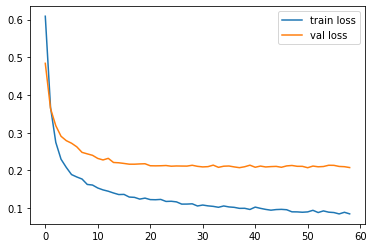

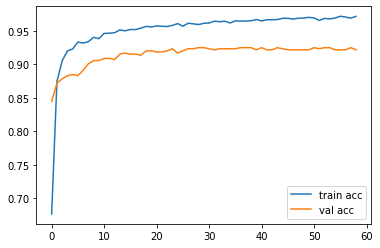

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
Y_pred = model.predict_generator(test_set, verbose = True)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = list(training_set.class_indices.keys())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

C:\Users\SAKSHAM\AppData\Local\Temp\ipykernel_15988\3787602794.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_set, verbose = True)


20/20 [==============================] - 6s 305ms/step
Confusion Matrix
[[ 91 143]
 [136 254]]
Classification Report
              precision    recall  f1-score   support

      normal       0.40      0.39      0.39       234
   pneumonia       0.64      0.65      0.65       390

    accuracy                           0.55       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.55      0.55       624

